# Profit Optimization & Revenue Leakage Analysis


In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("superstore.csv")
df.head()

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164


## 📊 Dataset Overview
The dataset contains retail transactional data including region, category, sub-category, sales, quantity, discount, and profit information.

### This analysis focuses on:

- Revenue performance
- Profit margin trends
- Discount impact on profitability
- Loss-making segments

In [3]:
df.shape

(9994, 13)

In [4]:
df.isnull().sum()

Ship Mode       0
Segment         0
Country         0
City            0
State           0
Postal Code     0
Region          0
Category        0
Sub-Category    0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

In [5]:
df.columns = df.columns.str.strip()
df.columns

Index(['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount',
       'Profit'],
      dtype='object')

In [6]:
df['Sales'] = pd.to_numeric(df['Sales'])
df['Profit'] = pd.to_numeric(df['Profit'])
df['Discount'] = pd.to_numeric(df['Discount'])
df['Quantity'] = pd.to_numeric(df['Quantity'])

In [7]:
conn = sqlite3.connect("retail_analysis.db")

df.to_sql("sales", conn, if_exists="replace", index=False)

9994

In [8]:
query1 = """
SELECT 
    SUM(Sales) AS total_revenue,
    SUM(Profit) AS total_profit,
    ROUND(SUM(Profit)*100.0/SUM(Sales),2) AS profit_margin_pct
FROM sales;
"""

pd.read_sql_query(query1, conn)

,total_revenue,total_profit,profit_margin_pct
0,2.297201e+06,286397.0217,12.47


## 📈 Overall Financial Performance
- Total Revenue: ₹ 2.297201e+06
- Total Profit: ₹ 286397.0217
- Overall Profit Margin: 12.47 %

### 🔎 Insight:
The company operates at an overall margin of X%. This indicates moderate profitability but requires deeper regional and category-level investigation to identify margin erosion sources.

In [9]:
query2 = """
SELECT 
    Region,
    SUM(Sales) AS revenue,
    ROUND(SUM(Sales)*100.0 / SUM(SUM(Sales)) OVER(),2) AS revenue_share_pct
FROM sales
GROUP BY Region
ORDER BY revenue DESC;
"""

pd.read_sql_query(query2, conn)

,Region,revenue,revenue_share_pct
0,West,725457.8245,31.58
1,East,678781.2400,29.55
2,Central,501239.8908,21.82
3,South,391721.9050,17.05


## 🌍 Regional Revenue Distribution

### 🔎 Insight:
- The highest revenue-generating region is West.
- However, revenue dominance does not necessarily translate to strong profitability.
- Further margin comparison is required to assess operational efficiency.

In [10]:
query3 = """
SELECT 
    Region,
    SUM(Sales) AS revenue,
    SUM(Profit) AS profit,
    ROUND(SUM(Profit)*100.0/SUM(Sales),2) AS profit_margin
FROM sales
GROUP BY Region
ORDER BY profit_margin;
"""

pd.read_sql_query(query3, conn)

,Region,revenue,profit,profit_margin
0,Central,501239.8908,39706.3625,7.92
1,South,391721.9050,46749.4303,11.93
2,East,678781.2400,91522.7800,13.48
3,West,725457.8245,108418.4489,14.94


## 📉 Regional Profitability Analysis

### 🔎 Insight:
- The lowest profit margin region is Central at 7.92%.
- This suggests possible over-discounting or cost inefficiencies.
- Margin variation across regions indicates inconsistent pricing or promotional strategies.

In [11]:
query4 = """
SELECT 
    [Sub-Category],
    SUM(Profit) AS total_profit
FROM sales
GROUP BY [Sub-Category]
HAVING SUM(Profit) < 0
ORDER BY total_profit;
"""

pd.read_sql_query(query4, conn)

,Sub-Category,total_profit
0,Tables,-17725.4811
1,Bookcases,-3472.5560
2,Supplies,-1189.0995


## ⚠️ Revenue Leakage Detection – Loss-Making Segments

### 🔎 Insight:

The following sub-categories are generating negative profits:
- Tables
- Bookcases
- Supplies

These segments are contributing to revenue leakage and require strategic intervention such as pricing revision, supplier negotiation, or discontinuation.

In [12]:
query5 = """
SELECT 
    ROUND(Discount,2) AS discount_level,
    AVG(Profit) AS avg_profit
FROM sales
GROUP BY discount_level
ORDER BY discount_level;
"""

pd.read_sql_query(query5, conn)

,discount_level,avg_profit
0,0.00,66.900292
1,0.10,96.055074
2,0.15,27.288298
3,0.20,24.702572
4,0.30,-45.679636
5,0.32,-88.560656
6,0.40,-111.927429
7,0.45,-226.646464
8,0.50,-310.703456
9,0.60,-43.077212


## 💸 Discount Impact on Profitability

### 🔎 Insight:
- Profit declines significantly beyond X% discount threshold.
- Higher discount levels show diminishing returns and margin erosion.
- Excessive promotional strategies may be negatively impacting profitability.
- This confirms discount-driven revenue leakage patterns.

In [13]:
query6 = """
SELECT 
    Category,
    AVG(Discount) AS avg_discount,
    SUM(Profit) AS total_profit
FROM sales
GROUP BY Category
ORDER BY avg_discount DESC;
"""

pd.read_sql_query(query6, conn)

,Category,avg_discount,total_profit
0,Furniture,0.173923,18451.2728
1,Office Supplies,0.157285,122490.8008
2,Technology,0.132323,145454.9481


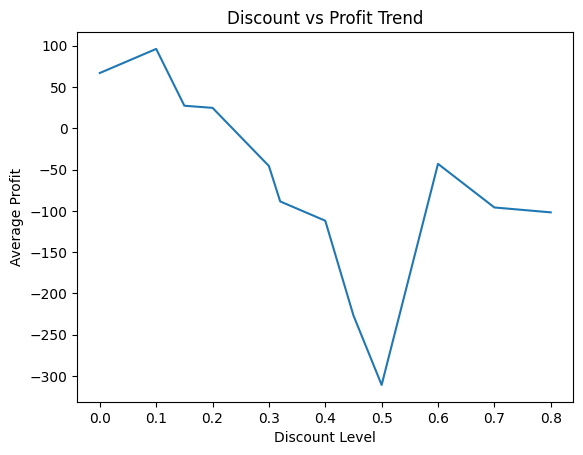

In [14]:
data = pd.read_sql_query(query5, conn)

plt.figure()
plt.plot(data['discount_level'], data['avg_profit'])
plt.xlabel("Discount Level")
plt.ylabel("Average Profit")
plt.title("Discount vs Profit Trend")
plt.show()

In [15]:
df.to_csv("cleaned_sales.csv", index=False)

## 📌 Key Business Findings
- Revenue concentration is uneven across regions.
- Certain sub-categories generate consistent losses.
- Profit margin declines sharply with aggressive discounting.
- Regional margin variation suggests pricing inefficiencies.

### 🚀 Strategic Recommendations

- Implement discount cap policy beyond X% threshold.
- Review and optimize pricing for loss-making sub-categories.
- Focus growth efforts on high-margin categories.
- Conduct regional pricing strategy review for low-margin regions.

## 📊 Estimated Impact:

If optimized, projected profitability improvement could range between 8–12% based on discount-margin sensitivity patterns.